In this notebook we will explore using Q-Learning as a means of generating optimal paths on simple graphs.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import time
%matplotlib inline

### Define a Simple Graph using NetworkX

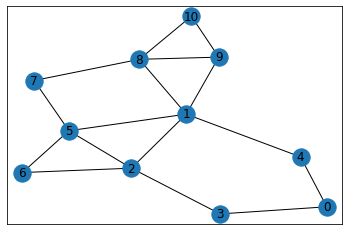

In [2]:
# Define the edges of the graph
edges = [(0,4), (4,0), (0,3), (3,0), (1,2), (2,1), (1,4), (4,1), (1,8), (8,1), (1,9), (9,1),
         (2,3), (3,2), (2,6), (6,2), (1,5), (5,1), (2,5), (5,2), (5,6), (6,5), (7,8), (8,7), 
         (7,5), (5,7), (8,9), (9,8), (8,10), (10,8), (9,10), (10,9)]
# Create the graph object 
G = nx.Graph()
# Create nodes as edges as defined in the list 
G.add_edges_from(edges)
pos = nx.spring_layout(G)
# Draw the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()

We can access the graph nodes with G[node].

In [3]:
G[10]

AtlasView({8: {}, 9: {}})

We see here that nodes 8 and 9 are connected to node 10.

### Finding the Shortest Path from Node 0 to Node 10

To apply Q-Learning we must first define two matrices, R and Q.  The R matrix is the rewards matrix.  Since reaching node 10 is our goal, we will give a reward to the nodes which are attached to 10, and a reward of 0 otherwise.

#### Define the R maxtrix

In [13]:
# We have 11 nodes, so define an 11x11 matrx of 0s
R = np.matrix(np.zeros(shape=(11,11)))
# For each node that is connected to 10, give a reward of 100
for x in G[10]:
    R[x,10]=100

Next, we define the Q matrix.  The learning algorithm will update these values by starting at different nodes and trying to reach the goal.  To start with, we initialize all possible actions (two nodes that are attached by an edge) to have a value of 0, and impossible actions we will set to -100.

#### Define the Q matrix

In [14]:
# Again start with an 11x11 matrix
Q = np.matrix(np.zeros(shape=(11,11)))
# Set each entry to be -100
Q -= 100
# For each node in the graph, G, find all connected nodes
for node in G.nodes:
    # For each of these, set the entries to 0
    for x in G[node]:
        Q[node,x] = 0
        Q[x,node] = 0

In [15]:
# Displaying the starting Q matrix
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10
0,-100.0,-100.0,-100.0,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,0.0,-100.0,0.0,0.0,-100.0,-100.0,0.0,0.0,-100.0
2,-100.0,0.0,-100.0,0.0,-100.0,0.0,0.0,-100.0,-100.0,-100.0,-100.0
3,0.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
5,-100.0,0.0,0.0,-100.0,-100.0,-100.0,0.0,0.0,-100.0,-100.0,-100.0
6,-100.0,-100.0,0.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0
7,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,0.0,-100.0,-100.0
8,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,0.0,0.0
9,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,0.0


### Q-Learning Terms:
er - exploration rate (random)

lr - learning rate (The learning rate or step size determines to what extent newly acquired information overrides old information. A factor of 0 makes the agent learn nothing (exclusively exploiting prior knowledge), while a factor of 1 makes the agent consider only the most recent information (ignoring prior knowledge to explore possibilities).

discount factor - (determines the importance of future rewards. A factor of 0 will make the agent "myopic" (or short-sighted) by only considering current rewards, while a factor approaching 1 will make it strive for a long-term high reward)

#### Q-Learning Functions

In [16]:
def next_number(start, er):
    """
    From a node, determine where to go next.
    """
    # Choose a random number
    random_value = random.uniform(0,1)
    # If this is below the er threshold, the next action is chosen randomly
    if random_value < er:
        # The possible actions will be all attached nodes
        sample = G[start]
    
    # Else, choose the possible action that has the highest Q value
    # Note - this can return multiple - so choose one at random after
    else:
        sample = np.where(Q[start,] == np.max(Q[start,]))[1]
    # Select one node from sample at random
    next_node = int(np.random.choice(sample,size=1))
    return next_node

In [17]:
def updateQ(node1, node2, lr, discount):
    """
    After an action is chosen, update the Q matrix.
    """
    # Find the index of the highest Q-value in the node 2 row
    max_index = np.where(Q[node2,] == np.max(Q[node2,]))[1]
    # If there are more than one, choose one at random
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size=1))
    else:
        max_index = int(max_index)
    
    # Get this max Q-value in the node 2 row 
    max_value = Q[node2, max_index]
    
    # Update this Q-value
    Q[node1, node2] = int((1-lr)*Q[node1,node2] + lr*(R[node1, node2] + discount*max_value))

In [18]:
def learn(er, lr, discount, episodes, nodes):
    """
    For a user defined number of episodes, create paths and update the Q matrix.
    """
    for i in range(episodes):
        # Choose a random starting node 
        start = np.random.randint(0,nodes)
        # Determine the next action
        next_node = next_number(start, er)
        # Update the Q matrix
        updateQ(start, next_node, lr, discount)

In [19]:
def shortest_path(begin, end):
    """
    Determine the shortest path between two nodes.  At each step, we want to 
    select the attached node with the highest Q-value.
    """
    # Create the path list
    path=[begin]
    # The next node is the possible action with the highest Q-value
    next_node = np.argmax(Q[begin,])
    # Add this to path
    path.append(next_node)
    # Continue in this way until you reach the end goal
    while next_node != end:
        next_node = np.argmax(Q[next_node,])
        path.append(next_node)
    return path

### Learning on our Graph, G

In [20]:
# Try:
# exploration rate = 0.5
# learning rate = 0.5
# discount = 0.8
# episodes = 10,000

# See how long the learning requires 
start = time.time()
learn(0.5, 0.5, 0.8, 10000, 11)
end = time.time()
print('{} seconds to learn.'.format(end - start))

0.6383283138275146 seconds to learn.


In [21]:
# Check the final Q matrix
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10
0,-100.0,-100.0,-100.0,107.0,135.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,135.0,-100.0,135.0,135.0,-100.0,-100.0,215.0,215.0,-100.0
2,-100.0,171.0,-100.0,107.0,-100.0,135.0,107.0,-100.0,-100.0,-100.0,-100.0
3,107.0,-100.0,135.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,107.0,171.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
5,-100.0,171.0,135.0,-100.0,-100.0,-100.0,107.0,171.0,-100.0,-100.0,-100.0
6,-100.0,-100.0,135.0,-100.0,-100.0,135.0,-100.0,-100.0,-100.0,-100.0,-100.0
7,-100.0,-100.0,-100.0,-100.0,-100.0,135.0,-100.0,-100.0,215.0,-100.0,-100.0
8,-100.0,171.0,-100.0,-100.0,-100.0,-100.0,-100.0,171.0,-100.0,215.0,271.0
9,-100.0,171.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,215.0,-100.0,271.0


#### Determine the shortest path between 0 and 10

In [22]:
shortest_path(0,10)

[0, 4, 1, 8, 10]

### Try on a Larger Randomly Generated Graph

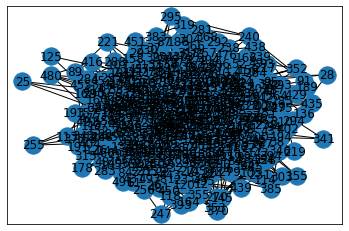

In [24]:
# Use NetworkX to generate a random graph with 500 nodes and 2500 edges
G = nx.gnm_random_graph(500,2500, seed=0)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()

#### Determine the Shortest Path between Node 0 and Node 499

In [25]:
# Define R
# Set = 100 if attached to 499 - else = 0
R = np.matrix(np.zeros(shape=(500,500)))
for x in G[499]:
    R[x,499]=100

In [26]:
# Define Q
# Set =-100 if two nodes are not attached - else =0
Q = np.matrix(np.zeros(shape=(500,500)))
Q -= 100
for node in G.nodes:
    for x in G[node]:
        Q[node,x] = 0
        Q[x,node] = 0

In [27]:
# Learn the Q Matrix
# Try er = 0.5
# lr = 0.5
# discount = 0.8
# episodes = 10,000
start = time.time()
learn(0.5, 0.5, 0.8, 10000, 500)
end = time.time()
print('{} seconds to train.'.format(end - start))

0.6712050437927246 seconds to train.


In [29]:
# Determine the shortest path
shortest_path(0,499)

[0, 41, 243, 195, 499]